# Make design and compute t-Maps

Here, we define which timepoints belong to the task and which to the rest condition.
To construct average maps of the z-scored timecoruses and statistical t-Maps, we use a crude but robust method of taking a boxcar function shifted by 6 seconds and a two sample t-test comparing activity and rest timepoints. This simplistic approach has been used sucessfully in [Wegrzyn et al. 2018](https://dx.doi.org/10.1371/journal.pone.0204338).

### import modules

In [1]:
import pickle

import pandas as pd
import numpy as np

from nilearn import input_data, plotting, datasets, image
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('poster')
sns.set_style('ticks')

### load data

In [4]:
data_df = pd.read_csv('../data/interim/csv/info_epi_zscored_zdiff_df.csv',index_col=[0],header=0)

In [ ]:
data_df.tail()

## make t maps

because the data has already been preprocessed and z-scored, we use a masker that reads the data raw/without modulating them further.

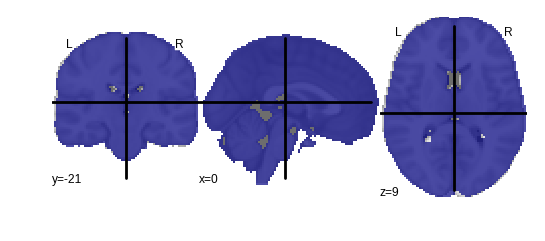

In [6]:
masker = input_data.NiftiMasker('../data/external/MNI152_T1_2mm_brain_mask.nii.gz').fit()
plotting.plot_roi(masker.mask_img_);

### we have blocks of 10 TRs, which we shift by one TR to account for the HRF delay

In [12]:
def make_blocks():
    """create a design where each resting timepoint is indicated by -1 and each task timepoint by +1"""
    
    # make 2 lists, one with -1 and one with +1
    my_cond = [([-1])*10,([1])*10]
    
    # here we collect the indices of our final design
    conds = []
    # for each number from 0 to 19 
    for i in range(20):
        # get the list with -1 if i is odd,
        # get the ilst with +1 if i is even
        conds+=my_cond[i%2]
        
    # shift by two TR, the first two volumes are rest as well
    conds = [-1, -1]+conds
    
    # after the shift, cut into shape again
    conds = conds[:200]
    
    return conds

In [13]:
conds = make_blocks()
print(conds)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1]


Store for later re-use in other notebooks:

In [14]:
with open('../models/conds.p', 'wb') as f:
    pickle.dump(conds, f)

### add block information to index of dataframe

Example:

In [ ]:
p_name = data_df.index[-1]
p_name

In [16]:
def make_df(p_name,data_df,metric='z-scored',masker=masker,conds=conds):
    """put fmri data into table where the index indicates if the volume is rest or task"""
    
    # get the filename
    fmri_im = data_df.loc[p_name,metric]   
    # read the data out
    fmri_data = masker.transform(fmri_im)
    # put into table
    fmri_df = pd.DataFrame(fmri_data)
    # add design to index
    fmri_df.index=[conds,fmri_df.index]

    return fmri_df

In [17]:
fmri_df = make_df(p_name,data_df)

In [18]:
fmri_df.tail(20)

0         1         2         3         4         5         6       \
 1 180 -1.442484 -1.263756 -1.068097 -1.236458 -0.986223 -1.507914 -1.138462   
   181  1.270538  1.557221  1.755796  1.481916  1.823359  1.149027  1.339709   
-1 182  1.204416  0.625950  0.208696  1.090842  0.619486  1.247595  0.982895   
   183 -0.631412 -0.893783 -1.031883 -0.575897 -0.787572 -0.570541 -0.538142   
   184 -0.428666 -0.897422 -1.071823 -0.584656 -0.971732  0.053923 -0.251628   
   185  0.289509  0.169782  0.106484  0.063344  0.026276  0.014806  0.036585   
   186 -0.149413 -0.557745 -0.677377 -0.032214 -0.308476  0.294377  0.194890   
   187  0.676571  0.687696  0.643926  0.227681  0.156643  0.227815  0.000047   
   188  0.022679 -0.448656 -0.871846 -0.305589 -0.750009  0.344146 -0.049484   
   189 -0.600160 -0.753662 -0.653631 -0.410514 -0.659940  0.307775  0.001654   
   190 -1.082321 -0.724270 -0.366218 -0.598133 -0.161233 -1.209514 -0.739056   
   191  0.337799  0.588669  0.902073  0.771750  0.967490  1.098294  1.200692   
 1 192  2.621402  2.797501  2.554864  2.673553  2.843208  1.934065  2.296690   
   193  0.368843  0.637703  0.729152  0.341669  0.402253  0.360223  0.110668   
   194 -1.070478 -0.807793 -0.638777 -0.568734 -0.443385 -0.443983 -0.355281   
   195 -0.689765 -0.374805 -0.175062 -1.092045 -0.838635 -1.229627 -1.183166   
   196 -2.019724 -1.528487 -0.866155 -1.915602 -1.583876 -1.575925 -1.561693   
   197 -0.816734 -0.323890  0.079987 -0.690428 -0.265431 -1.092955 -0.646340   
   198 -0.211368  0.162948  0.392450 -0.554965 -0.329977 -0.913958 -0.934726   
   199 -0.377932 -0.590324 -0.873215 -0.922967 -1.012948 -1.353024 -1.265377   

          7         8         9         ...       228473    228474    228475  \
 1 180 -0.790190 -1.123461 -1.334607    ...     0.684382  0.613726 -1.541163   
   181  1.665166  1.105908  0.870877    ...     0.610649  0.873603  1.220086   
-1 182  0.642801  0.955751  0.993168    ...     0.326808  0.093045 -1.460650   
   183 -0.589619 -0.481641 -0.859432    ...    -0.593944 -0.451079  0.356804   
   184 -0.539166  0.226217  0.306696    ...     1.222635  0.932027  0.819883   
   185  0.093995  0.138699  1.218675    ...     0.189846  0.171498  1.168027   
   186  0.082142  0.088885  0.126472    ...     0.370502  0.480553  1.400372   
   187 -0.171675 -0.211321  1.054352    ...     0.396879  0.716511  0.261146   
   188 -0.514524  0.333912  0.573125    ...    -0.263014 -0.420159 -0.110165   
   189 -0.225995  0.389536 -1.120658    ...     0.356199  0.270664 -2.007449   
   190 -0.236490 -0.931122 -2.207039    ...    -0.636217 -0.168561  0.886844   
   191  1.389926  1.452699  0.517961    ...     1.917478  1.526556  0.576279   
 1 192  2.409714  1.978979  0.413246    ...    -0.171817 -0.149662  0.749296   
   193 -0.059509 -0.077555 -0.835437    ...    -0.868632 -0.969861  1.237911   
   194 -0.296215 -0.459219 -0.361175    ...    -0.714470 -0.592482 -0.301770   
   195 -1.090089 -1.174711 -0.868357    ...    -0.204318 -0.742465 -0.675538   
   196 -1.383820 -1.264194 -1.429890    ...    -1.501439 -1.060194 -0.678377   
   197 -0.186812 -0.734261 -1.061619    ...    -0.763663 -0.863922 -0.464444   
   198 -0.857768 -1.044190 -1.090979    ...    -0.779513 -0.986982 -0.580808   
   199 -1.262091 -1.385251 -2.206766    ...    -0.586780 -0.603218 -1.841918   

          228476    228477    228478    228479    228480    228481    228482  
 1 180 -2.112125 -2.347162 -2.100206 -1.007482 -1.382912 -1.648368 -0.907881  
   181  1.250708  1.230148  1.171551  1.008408  1.049894  0.976321  1.305532  
-1 182 -1.403815 -1.086150 -0.551350 -1.267795 -1.116133 -0.766767 -0.717047  
   183  0.409567  0.120425 -0.407390  0.001002  0.000950 -0.162816 -0.201470  
   184  0.665701  0.496985  0.377843  0.845590  0.611070  0.372170  0.747194  
   185  1.123177  1.105600  1.087269  0.810453  0.748388  0.764864  0.560368  
   186  1.774154  1.675366  1.135592  1.185389  1.457036  1.325053  0.792365  
   187  0.648079

### make average z-map

In [62]:
def make_z(p_name, data_df,metric='z-scored'):
    """compute average z-map"""

    # get data of patient into table
    fmri_df = make_df(p_name, data_df,metric=metric)

    # use table index to select activity (+1) and rest (-1) volumes
    act = fmri_df.loc[1]
    rest = fmri_df.loc[-1]
    
    # make difference between act and rest
    diff_mean = act.mean()-rest.mean()
    # get difference back into brain space
    diff_im = masker.inverse_transform(diff_mean)

    # store the file and add it to the data_df table for later access
    out_name = '../data/interim/nii/meanMap_%s_%s.nii' % (metric,p_name)
    diff_im.to_filename(out_name)
    
    data_df.loc[p_name, 'meanMap_%s'%metric] = out_name
    
    return data_df

### Example:

#### with original data

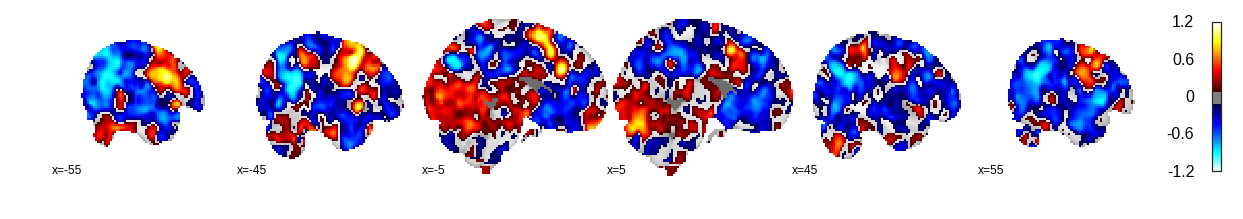

In [21]:
metric = 'z-scored'
data_df = make_z(p_name,data_df,metric=metric)
z_im = data_df.loc[p_name,'meanMap_%s'%metric]
plotting.plot_stat_map(z_im,threshold=.1,display_mode='x',cut_coords=[-55,-45,-5,5,45,55]);

In [ ]:
data_df.tail()

#### with difference data

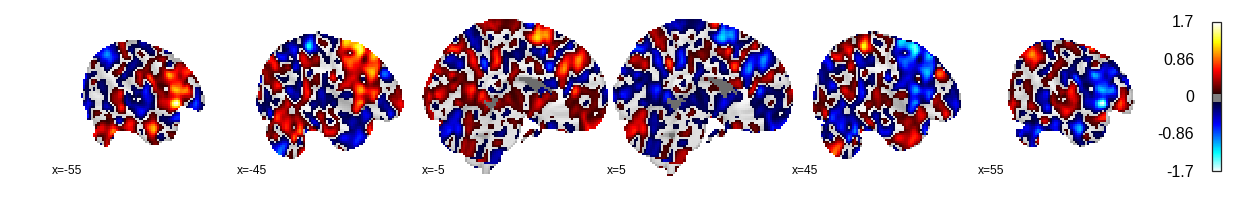

In [25]:
metric = 'z-scored-diff'
data_df = make_z(p_name,data_df,metric=metric)
z_im = data_df.loc[p_name,'meanMap_%s'%metric]
plotting.plot_stat_map(z_im,threshold=.1,display_mode='x',cut_coords=[-55,-45,-5,5,45,55]);

In [ ]:
data_df.tail()

#### do this for all patients

In [59]:
from datetime import datetime

In [ ]:
for p_name in data_df.index:
    print('%s %s'%(p_name,datetime.now()))
    for metric in ['z-scored','z-scored-diff']:
        print(metric)
        try:
            data_df = make_z(p_name,data_df,metric=metric)
        except:
            print('did not work for %s'%p_name)

### make average t-map

In [86]:
def make_t(p_name, data_df):
    """compute very primitive two-sample t-test, using only raw volume data and boxcar design"""

    # get data of patient into table
    fmri_df = make_df(p_name, data_df)

    # use table index to select activity (+1) and rest (-1) volumes
    act = fmri_df.loc[1]
    rest = fmri_df.loc[-1]
    # compute two-sample t-test in each voxel
    t, p = stats.ttest_ind(act, rest)
    # get t-values back into brain space
    t_im = masker.inverse_transform(t)

    # store the file and add it to the data_df table for later access
    out_name = '../data/interim/tMaps/tMap_%s.nii' % p_name
    t_im.to_filename(out_name)
    
    data_df.loc[p_name, 'tMap'] = out_name
    
    return data_df

#### Example:

In [87]:
data_df = make_t(p_name,data_df)

In [ ]:
data_df.tail()

In [ ]:
t_im = data_df.loc[p_name,'tMap']
t_im

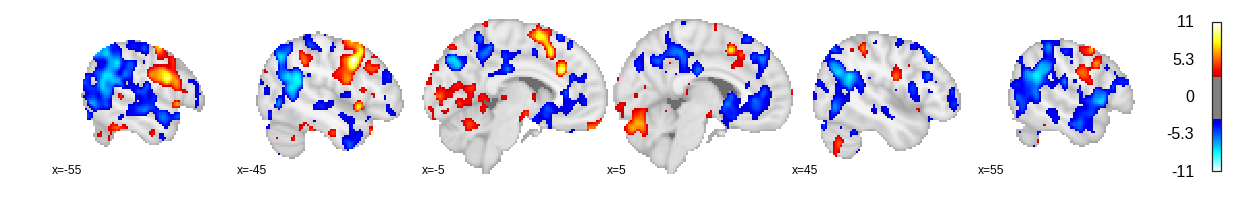

In [90]:
plotting.plot_stat_map(t_im,threshold=3,display_mode='x',cut_coords=[-55,-45,-5,5,45,55]);

In [91]:
from datetime import datetime

In [ ]:
for p_name in data_df.index:
    print('%s %s'%(datetime.now(),p_name))
    try:
        data_df = make_t(p_name,data_df)
    except:
        print('did not work for %s'%p_name)

### remove patients with incomplete data

There are patients whose fMRI datasets contain less than 200 volumes. These datasets have to be removed:

In [ ]:
data_df.tail()

In [94]:
clean_data_df = data_df.dropna()

In [ ]:
clean_data_df.tail()

In [96]:
data_df.shape, clean_data_df.shape

((143, 9), (140, 9))

### how many unique patients are there?

In [99]:
clean_data_df.groupby('code').count().shape

(96, 8)

### store data frame

In [100]:
clean_data_df.to_csv('../data/interim/csv/info_epi_zscored_zdiff_summarymaps_df.csv')

### summary  

We now have two new pieces of data: A design matrix which allows us to compare task with rest; and maps with t-values for each patient, which allow us to predict language lateralization with an LI approach. We will use these t-Maps in the next notebook to run it through our 2D-LI module.


**************

< [Previous](03-mw-make-difference-ims.ipynb) | [Contents](00-mw-overview-notebook.ipynb) | [Next >](05-mw-identify-inconclusive.ipynb)